In [81]:
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.tree as tree
from imblearn import over_sampling
from imblearn import under_sampling
from sklearn import ensemble
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

In [3]:
data_raw = pd.read_csv('./nshap_w1_w2_w3_core_disposition.csv',
                       low_memory=False)
#Stacking
#SMOTE

## Data cleaning

In [4]:
data_raw

,ID,SAMPLETYPE,w3DISP_GRP,w3DECEASED,ID_as_string,w2DISP_GRP,w2DECEASED,w1FI_ID,w1PATH,w1VERSION,...,w3IWDESCRIBE2,w3IWDESCRIBE3,w3IWDESCRIBE4,w3IWDESCRIBE5,w3AREACOMFORT,w3AREASAFE,w3AREAAMENITIES,w3AREAPRESENCE,w3CASEDIF,_merge
0,100005,1.0,5.0,0.0,100005.0,1.0,0.0,866808.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
1,100033,1.0,1.0,0.0,100033.0,1.0,0.0,169164.0,3.0,3.0,...,1.0,1.0,2.0,1.0,1.0,1.0,2.0,5.0,4.0,3
2,100067,1.0,1.0,0.0,100067.0,NaN,NaN,NaN,NaN,NaN,...,3.0,3.0,2.0,3.0,2.0,2.0,3.0,3.0,3.0,3
3,100080,1.0,1.0,0.0,100080.0,1.0,0.0,281481.0,6.0,2.0,...,1.0,1.0,5.0,1.0,1.0,1.0,2.0,3.0,4.0,3
4,100149,1.0,1.0,0.0,100149.0,NaN,NaN,NaN,NaN,NaN,...,3.0,2.0,2.0,2.0,1.0,1.0,1.0,3.0,4.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6064,199846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,1.0,1.0,2.0,1.0,1.0,2.0,5.0,4.0,2
6065,199898,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,4.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,2
6066,199931,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-3.0,-3.0,-3.0,-3.0,1.0,1.0,1.0,5.0,2.0,2
6067,199954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,4.0,1.0,1.0,1.0,3.0,5.0,1.0,2


In [5]:
# Since the data contains original cohort and follow-up cohort, we need to filter out the follow-up cohort
print("Total observations: {}".format(len(data_raw)))
data_w1 = data_raw[~data_raw['w1WEIGHT_ADJ'].isnull()]
print("Removed follow-up {} respondents without W1 observations".format(len(data_raw) - len(data_w1)))
data_decease = data_w1[data_w1.notnull()].copy()
data_decease['deceased'] = data_decease['w3DECEASED']
data_decease.loc[data_decease['deceased'] == -9, ['deceased']] = np.nan
data_decease['deceased'].fillna(data_decease['w2DECEASED'], inplace=True)
data_decease.loc[data_decease['deceased'] == -9, ['deceased']] = np.nan
data_complete = data_decease[data_decease['deceased'].notnull()]
print("Removed follow-up {} respondents without disposition statuses".format(len(data_w1) - len(data_complete)))
print("Sample frame has {} respondents".format(len(data_complete)))


Total observations: 6069
Removed follow-up 3064 respondents without W1 observations
Removed follow-up 10 respondents without disposition statuses
Sample frame has 2995 respondents


In [6]:
data_complete['deceased'].value_counts()

0.0    2102
1.0     893
Name: deceased, dtype: int64

In [7]:
data = data_complete[['ID', 'deceased', 'w1WEIGHT_ADJ', 'w1AGE', 'w1SYSTOLIC_MEAN',
                      'w1BMI', 'w1HBA1C', 'w1CRP', 'w1DHEA_1', 'w1DHEA_2',
                      'w1SMOKECIG', 'w1ALCOHOL', 'w1PHYSACT', 'w1HRSSLEEP',
                      'w1EDUC', 'w1HSASSETS_RECODE', 'w1MARITLST', 'w1ETHGRP',
                      'w1GENDER',
                      'w1PHYSHLTH', 'w1MNTLHLTH', 'w1CONDITNS_3', 'w1WALKBLK']]

In [8]:
# Preprocessing binary variables,
## 在处理binary和ordinalvariable的时候针对原数据和新数据的处理过程和逻辑，比如str——》0、1
cat_col = ['ID', 'deceased', 'w1SMOKECIG', 'w1ALCOHOL', 'w1MARITLST',
           'w1ETHGRP', 'w1GENDER',
           'w1CONDITNS_3']
##bi_col
data_cat = data[data[cat_col].notnull()].copy()[cat_col]
for col in cat_col:
    data_cat[col] = data_cat[col].astype('category')
data_cat['w1married'] = np.where(data_cat['w1MARITLST'] == 'Married', 1, 0)
data_cat['w1raceblk'] = np.where(data_cat['w1ETHGRP'] == 'Married', 1, 0)
data_cat.drop('w1MARITLST', axis=1, inplace=True)
data_cat.drop('w1ETHGRP', axis=1, inplace=True)

In [9]:
# Preprocessing ordinal variables
ord_col = ['w1PHYSACT', 'w1EDUC', 'w1HSASSETS_RECODE',
           'w1PHYSHLTH', 'w1MNTLHLTH', 'w1WALKBLK']
data_ord = data[data[ord_col].notnull()].copy()[ord_col]
data_ord[data_ord < 0] = np.nan
data_ord.fillna(data_ord.mean(), inplace=True)

In [10]:
# Preprocessing continuous variables
con_col = ['w1WEIGHT_ADJ', 'w1AGE', 'w1SYSTOLIC_MEAN', 'w1BMI', 'w1HBA1C',
           'w1CRP', 'w1DHEA_1', 'w1DHEA_2', 'w1HRSSLEEP']
data_con = data[data[con_col].notnull()].copy()[con_col]
for col in con_col:
    data_con[col] = pd.to_numeric(data_con[col], errors='coerce')
data_con['w1dhea_mean'] = data_con[['w1DHEA_1', 'w1DHEA_2']].mean(axis=1)
data_con = data_con.drop(['w1DHEA_1', 'w1DHEA_2'], axis=1)
data_con[data_con < 0] = np.nan
data_con.fillna(data_con.mean(), inplace=True)
data_con.describe()

,w1WEIGHT_ADJ,w1AGE,w1SYSTOLIC_MEAN,w1BMI,w1HBA1C,w1CRP,w1HRSSLEEP,w1dhea_mean
count,2995.000000,2995.000000,2995.000000,2995.000000,2995.000000,2995.000000,2995.000000,2995.000000
mean,1.000914,69.307513,137.138234,29.095167,6.097641,3.194580,6.888366,52.921454
std,0.652064,7.857698,20.306078,6.078190,0.782456,4.848129,1.381350,109.835482
min,0.149840,57.000000,78.000000,14.063041,4.200000,0.000000,1.000000,1.510000
25%,0.610117,62.000000,122.500000,25.101870,5.700000,1.053500,6.000000,22.252500
50%,0.846541,69.000000,135.666672,28.793165,6.097641,3.194580,7.000000,46.205000
75%,1.233965,76.000000,149.000000,31.773318,6.097641,3.194580,8.000000,53.247500
max,11.354286,85.000000,233.000000,75.600655,14.200000,100.000000,13.000000,5000.000000


In [11]:
data = pd.concat([data_cat, data_ord, data_con], axis=1)
data_nona = data.dropna()
print("Removed {} respondents with missing values in categorical variables".format(len(data) - len(data_nona)))

Removed 0 respondents with missing values in categorical variables


In [13]:
data_nona.to_csv("./save_df.csv")

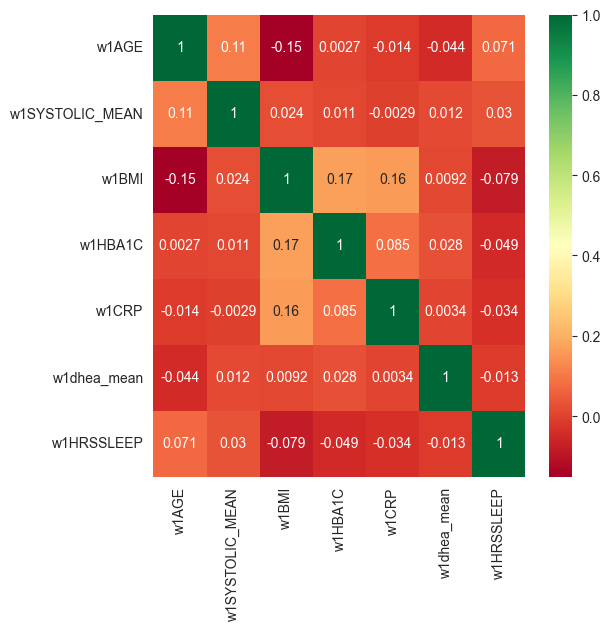

In [14]:
_, ax = plt.subplots(figsize=(6, 6))
columns = ['w1AGE', 'w1SYSTOLIC_MEAN', 'w1BMI', 'w1HBA1C',
           'w1CRP', 'w1dhea_mean', 'w1HRSSLEEP']
sns.heatmap(data[columns].corr(), annot=True, cmap='RdYlGn', ax=ax);
##加上分析的comment，from heatmap，变量之间的关系是什么样的
##要写comment在上面，每一步代码，口头解释
##直接在Jupyter notbook上写，代码和summary都要呈现在notebook，代码和结果的reaction
##每一步代码的效果和目的注释在notebook上的，参考case study

## Decision Tree

In [15]:
#减少不同model的variance，是pred更稳定，抵消缺点
#

data_nona = pd.read_csv('./save_df.csv')
seed = 42

In [17]:
data_x = data_nona[['w1WEIGHT_ADJ', 'w1AGE', 'w1SYSTOLIC_MEAN',
                    'w1BMI', 'w1HBA1C', 'w1CRP', 'w1dhea_mean',
                    'w1SMOKECIG', 'w1ALCOHOL', 'w1PHYSACT', 'w1HRSSLEEP',
                    'w1EDUC', 'w1HSASSETS_RECODE', 'w1married', 'w1raceblk',
                    'w1GENDER',
                    'w1PHYSHLTH', 'w1MNTLHLTH', 'w1CONDITNS_3', 'w1WALKBLK']]
predictor_names = ['Weight', 'Age', 'Systolic BP', 'BMI', 'HbA1c', 'CRP', 'DHEA',
                   'smoker', 'alcohol', 'physical activity', 'sleep',
                   'education', 'wealth', 'married', 'black race', 'gender',
                   'physical self-rated health', 'mental self-rated health',
                   'chronic conditions', 'walking 1 block']
feature_names = ['Age', 'Systolic BP', 'BMI', 'HbA1c', 'CRP', 'DHEA',
                 'smoker', 'alcohol', 'physical activity', 'sleep',
                 'education', 'wealth', 'married', 'black race', 'gender',
                 'physical self-rated health', 'mental self-rated health',
                 'chronic conditions', 'walking 1 block']
data_y = data_nona[['deceased']]
data_x.columns = predictor_names
# Then split into 60% training, 20% validation, and 20% testing
X_train_v, X_test, y_train_v, y_test = train_test_split(data_x, data_y,
                                                        test_size=0.2,
                                                        random_state=42)
# 0.25 x 0.8 = 0.2
X_train, X_val, y_train, y_val = train_test_split(X_train_v,
                                                  y_train_v,
                                                  test_size=0.25,
                                                  random_state=42)
X_train

,Weight,Age,Systolic BP,BMI,HbA1c,CRP,DHEA,smoker,alcohol,physical activity,sleep,education,wealth,married,black race,gender,physical self-rated health,mental self-rated health,chronic conditions,walking 1 block
2027,0.671996,72.0,130.5,33.062496,5.600000,2.97400,50.905001,0.0,0.0,4.0,7.0,3.0,3.649512,0,0,2.0,3.0,5.0,0.0,0.0
1349,1.193744,58.0,139.0,27.405882,6.097641,3.19458,52.921454,0.0,0.0,4.0,5.0,2.0,3.649512,0,0,1.0,3.0,3.0,0.0,0.0
1452,0.915176,67.0,140.0,26.453720,5.500000,0.63600,36.845001,0.0,1.0,4.0,7.0,3.0,5.000000,0,0,1.0,5.0,5.0,0.0,0.0
1751,0.422578,66.0,140.0,35.340797,6.400000,1.17400,74.494999,1.0,0.0,4.0,8.0,2.0,2.000000,0,0,1.0,3.0,2.0,0.0,0.0
1882,2.301125,76.0,128.5,34.332088,7.400000,0.20700,19.050000,1.0,1.0,3.0,8.0,2.0,2.000000,0,0,2.0,3.0,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1101,0.821570,71.0,118.5,21.948576,5.300000,0.45300,15.810000,0.0,0.0,0.0,7.0,2.0,3.649512,0,0,2.0,2.0,4.0,0.0,0.0
1171,0.550444,59.0,127.0,29.283794,9.100000,0.24400,18.320000,0.0,0.0,4.0,10.0,1.0,1.000000,0,0,2.0,2.0,2.0,0.0,0.0
701,0.827561,73.0,160.0,26.002075,6.100000,1.62400,75.785000,0.0,1.0,3.0,7.0,3.0,4.000000,0,0,2.0,4.0,4.0,0.0,0.0
2148,2.084293,60.0,131.0,34.515472,6.300000,0.61200,92.315002,0.0,1.0,4.0,6.0,4.0,4.000000,0,0,1.0,4.0,5.0,0.0,0.0


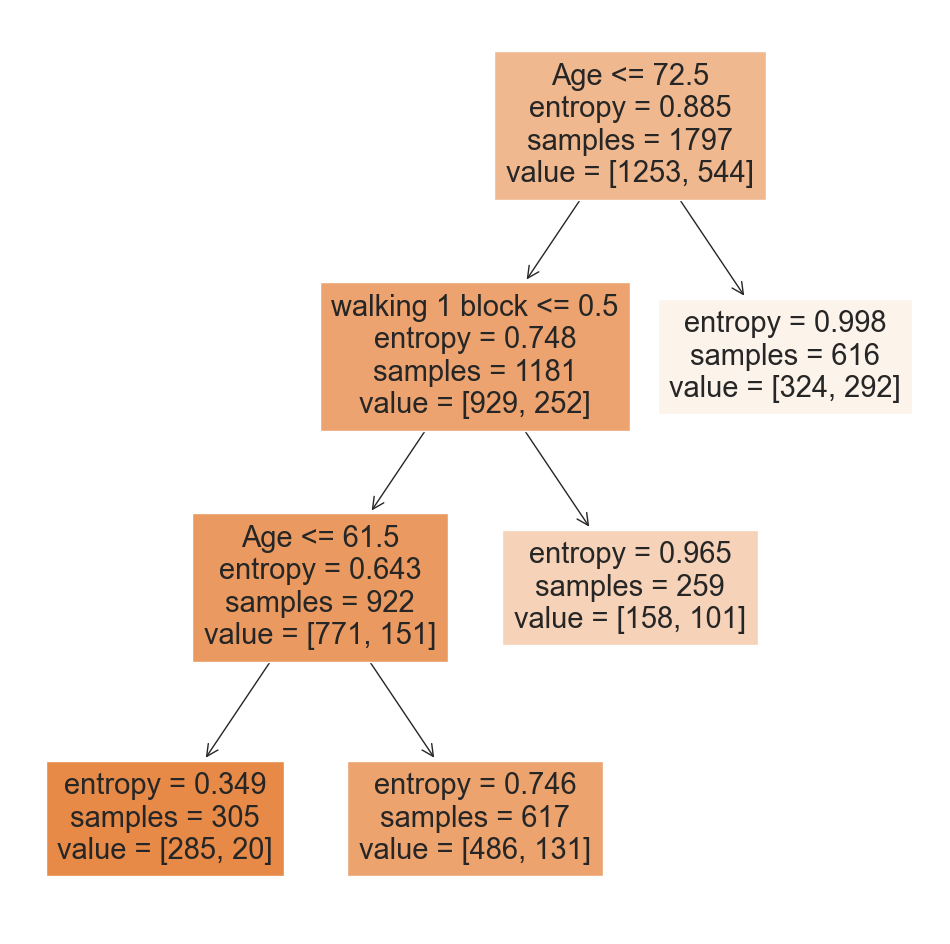

Performence on train set 0.6972732331663885
Performence on test set 0.7078464106844741
              precision    recall  f1-score   support

         0.0       0.71      1.00      0.83       424
         1.0       0.00      0.00      0.00       175

    accuracy                           0.71       599
   macro avg       0.35      0.50      0.41       599
weighted avg       0.50      0.71      0.59       599



/Users/lyu/Opt/anaconda3/envs/m1_torch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lyu/Opt/anaconda3/envs/m1_torch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lyu/Opt/anaconda3/envs/m1_torch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [32]:
# BOTH PRE-PRUNING AND POST_PRUNING (PYTHON PACKAGES TO AUTOMATE THIS PROCESS)
DT_clf = tree.DecisionTreeClassifier(random_state=seed, criterion="entropy", max_depth=None,
                                     min_impurity_decrease=0.01)
DT_clf.fit(X_train.drop(columns='Weight', inplace=False), y_train)

plt.figure(figsize=(12, 12))
tree.plot_tree(DT_clf, filled=True, feature_names=feature_names)
plt.show()

print("Performence on train set",
      metrics.accuracy_score(DT_clf.predict(X_train.drop(columns='Weight', inplace=False)), y_train))
y_pred = pd.DataFrame(DT_clf.predict(X_test.drop(columns='Weight', inplace=False)), columns=["deceased"])
print("Performence on test set", metrics.accuracy_score(y_pred, y_test))

print(metrics.classification_report(y_test, y_pred))

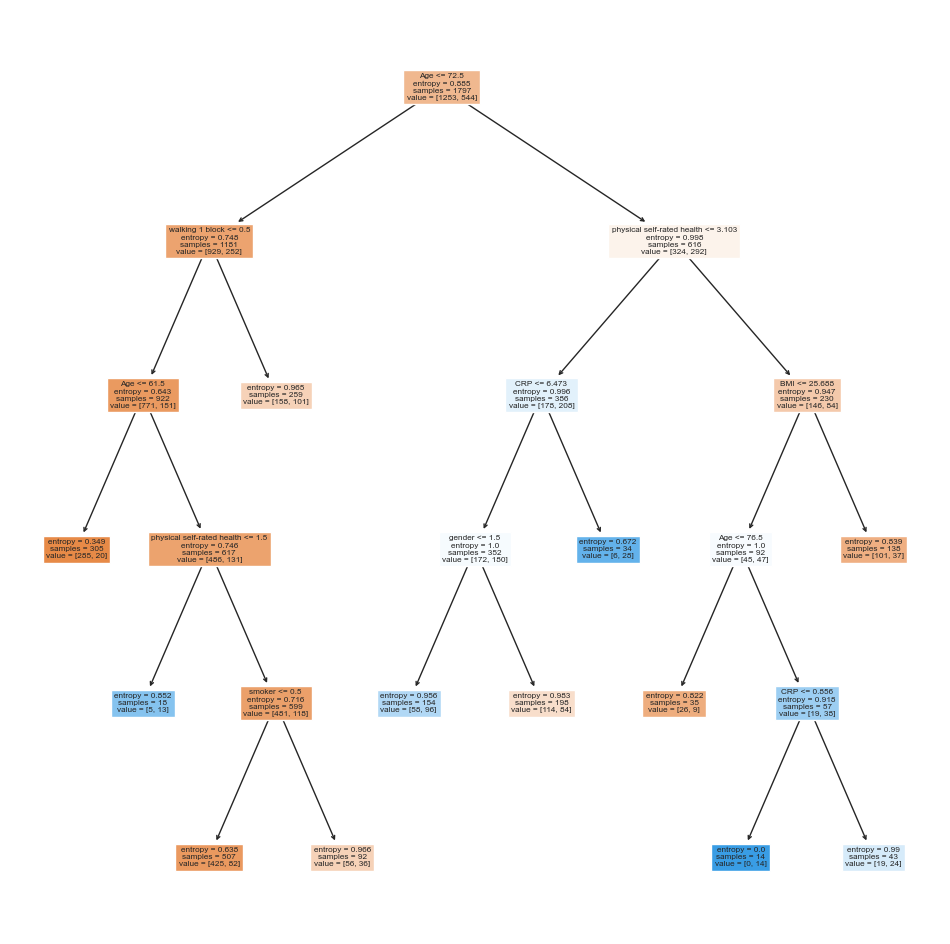

Performence on train set 0.7456872565386756
Performence on test set 0.7212020033388982
              precision    recall  f1-score   support

         0.0       0.75      0.90      0.82       424
         1.0       0.54      0.28      0.37       175

    accuracy                           0.72       599
   macro avg       0.65      0.59      0.60       599
weighted avg       0.69      0.72      0.69       599



In [33]:
DT_clf = tree.DecisionTreeClassifier(random_state=seed, criterion="entropy", max_depth=None,
                                     min_impurity_decrease=0.005)
DT_clf.fit(X_train.drop(columns='Weight', inplace=False), y_train)

plt.figure(figsize=(12, 12))
tree.plot_tree(DT_clf, filled=True, feature_names=feature_names)
plt.show()

print("Performence on train set",
      metrics.accuracy_score(DT_clf.predict(X_train.drop(columns='Weight', inplace=False)), y_train))
y_pred = pd.DataFrame(DT_clf.predict(X_test.drop(columns='Weight', inplace=False)), columns=["deceased"])
print("Performence on test set", metrics.accuracy_score(y_pred, y_test))

print(metrics.classification_report(y_test, y_pred))

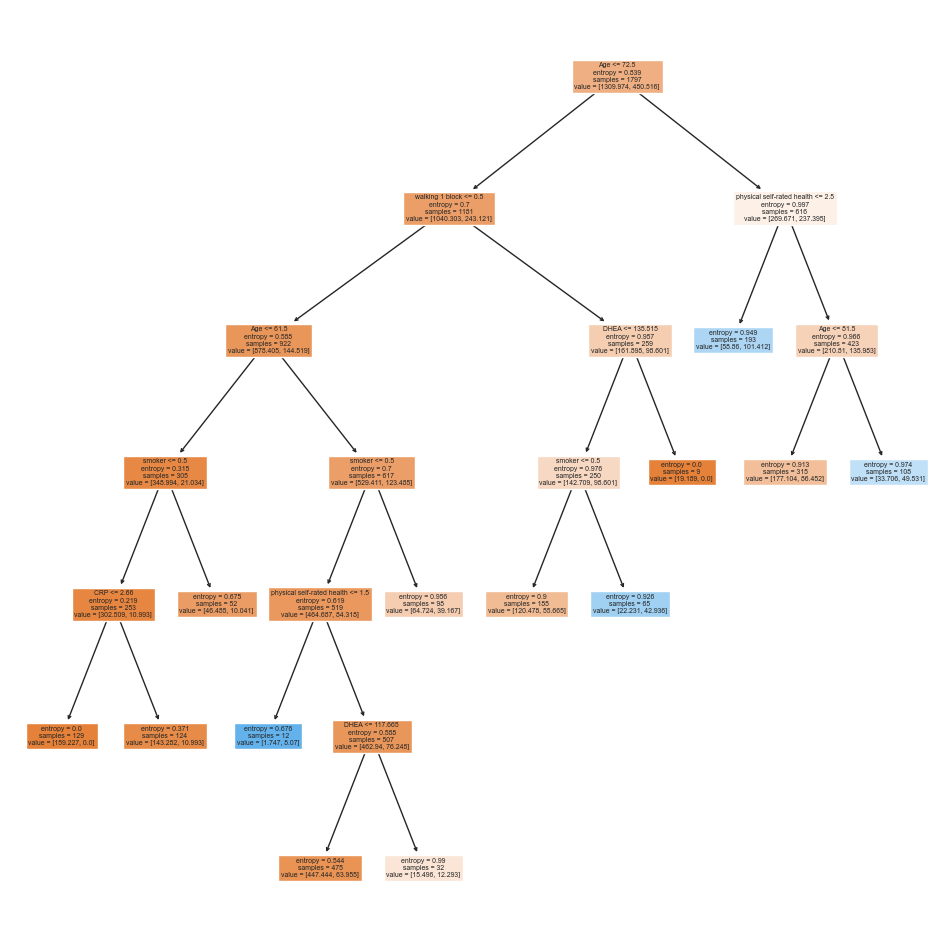

Performence on train set 0.7793283071245465
Performence on test set 0.7576064137668332
              precision    recall  f1-score   support

         0.0       0.79      0.91      0.85 443.2256796807058
         1.0       0.57      0.35      0.43 159.910779565578

    accuracy                           0.76 603.1364592462838
   macro avg       0.68      0.63      0.64 603.1364592462838
weighted avg       0.73      0.76      0.74 603.1364592462838



In [35]:
DT_clf = tree.DecisionTreeClassifier(random_state=seed, criterion="entropy", max_depth=None,
                                     min_impurity_decrease=0.005)
DT_clf.fit(X_train.drop(columns='Weight', inplace=False), y_train, sample_weight=X_train['Weight'])

plt.figure(figsize=(12, 12))
tree.plot_tree(DT_clf, filled=True, feature_names=feature_names)
plt.show()

print("Performence on train set",
      metrics.accuracy_score(DT_clf.predict(X_train.drop(columns='Weight', inplace=False)), y_train,
                             sample_weight=X_train['Weight']))
y_pred = pd.DataFrame(DT_clf.predict(X_test.drop(columns='Weight', inplace=False)), columns=["deceased"])
print("Performence on test set", metrics.accuracy_score(y_pred, y_test, sample_weight=X_test['Weight']))

print(metrics.classification_report(y_test, y_pred, sample_weight=X_test['Weight']))

In [34]:
print(X_train[y_train['deceased'] == 0]["Weight"].sum())
print(X_train[y_train['deceased'] == 1]["Weight"].sum())

1309.973718419689
480.515794426225


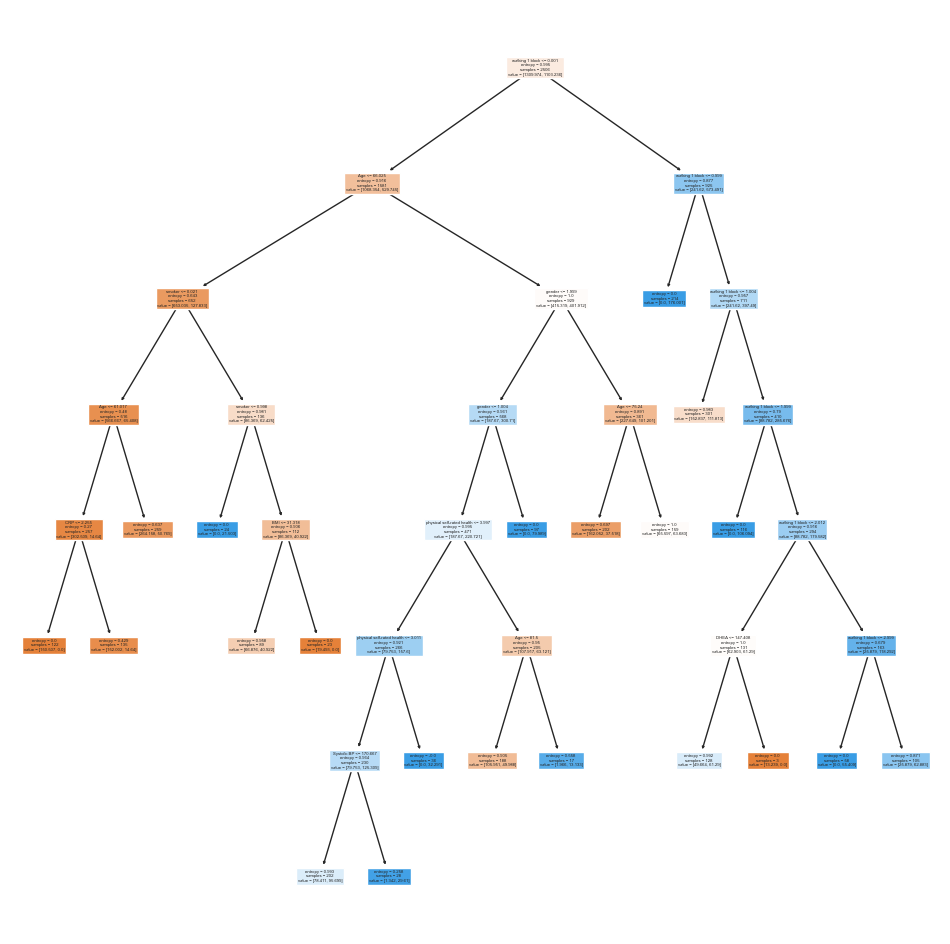

Performence on train set 0.7817862753422294
Performence on test set 0.7056290927262231
              precision    recall  f1-score   support

         0.0       0.78      0.83      0.81 443.2256796807058
         1.0       0.43      0.35      0.39 159.910779565578

    accuracy                           0.71 603.1364592462838
   macro avg       0.61      0.59      0.60 603.1364592462838
weighted avg       0.69      0.71      0.70 603.1364592462838



In [42]:
X_sm, y_sm = over_sampling.SMOTE(random_state=seed).fit_resample(X_train, y_train)
DT_clf = tree.DecisionTreeClassifier(random_state=seed, criterion="entropy", max_depth=None,
                                     min_impurity_decrease=0.005)
DT_clf.fit(X_sm.drop(columns='Weight', inplace=False), y_sm, sample_weight=X_sm['Weight'])

plt.figure(figsize=(12, 12))
tree.plot_tree(DT_clf, filled=True, feature_names=feature_names)
plt.show()

print("Performence on train set",
      metrics.accuracy_score(DT_clf.predict(X_sm.drop(columns='Weight', inplace=False)), y_sm,
                             sample_weight=X_sm['Weight']))
y_pred = pd.DataFrame(DT_clf.predict(X_test.drop(columns='Weight', inplace=False)), columns=["deceased"])
print("Performence on test set", metrics.accuracy_score(y_pred, y_test, sample_weight=X_test['Weight']))

print(metrics.classification_report(y_test, y_pred, sample_weight=X_test['Weight']))

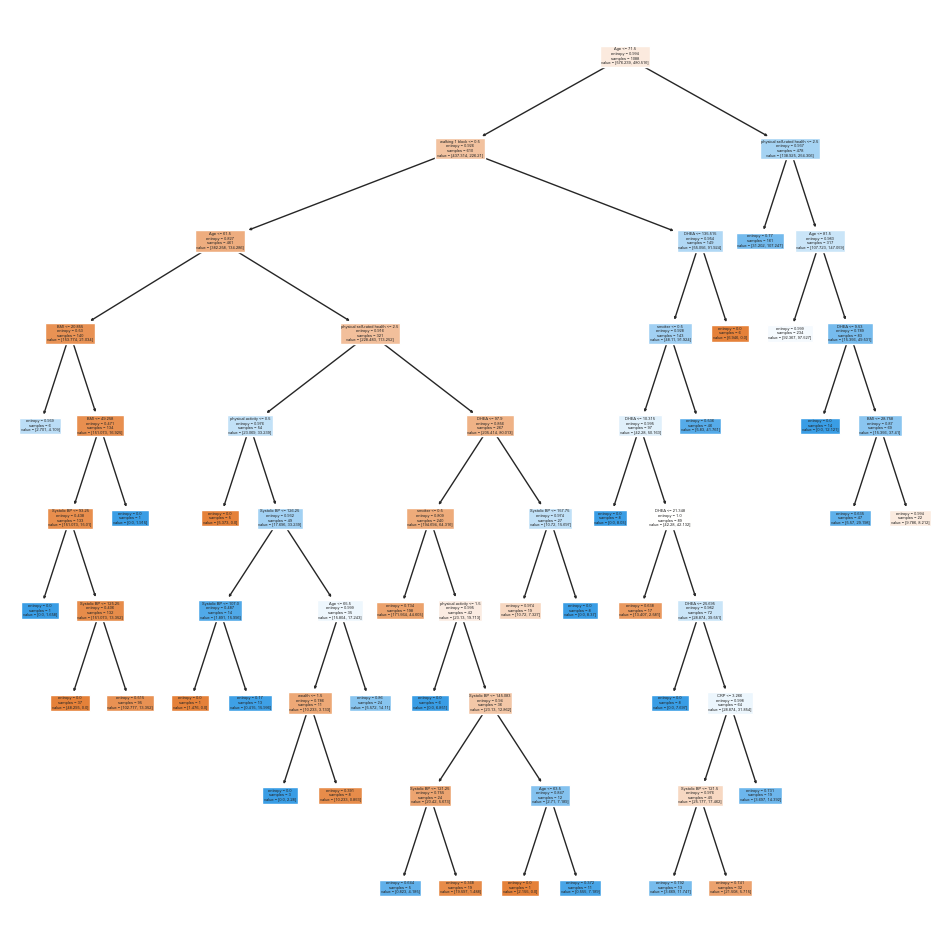

Performence on train set 0.7761720667758218
Performence on test set 0.6360291330007447
              precision    recall  f1-score   support

         0.0       0.85      0.62      0.71 443.2256796807058
         1.0       0.39      0.69      0.50 159.910779565578

    accuracy                           0.64 603.1364592462838
   macro avg       0.62      0.65      0.61 603.1364592462838
weighted avg       0.73      0.64      0.66 603.1364592462838



In [49]:
X_und, y_und = under_sampling.RandomUnderSampler(random_state=seed).fit_resample(X_train, y_train)
DT_clf = tree.DecisionTreeClassifier(random_state=seed, criterion="entropy", max_depth=None,
                                     min_impurity_decrease=0.005)
DT_clf.fit(X_und.drop(columns='Weight', inplace=False), y_und, sample_weight=X_und['Weight'])

plt.figure(figsize=(12, 12))
tree.plot_tree(DT_clf, filled=True, feature_names=feature_names)
plt.show()

print("Performence on train set",
      metrics.accuracy_score(DT_clf.predict(X_und.drop(columns='Weight', inplace=False)), y_und,
                             sample_weight=X_und['Weight']))
y_pred = pd.DataFrame(DT_clf.predict(X_test.drop(columns='Weight', inplace=False)), columns=["deceased"])
print("Performence on test set", metrics.accuracy_score(y_pred, y_test, sample_weight=X_test['Weight']))

print(metrics.classification_report(y_test, y_pred, sample_weight=X_test['Weight']))

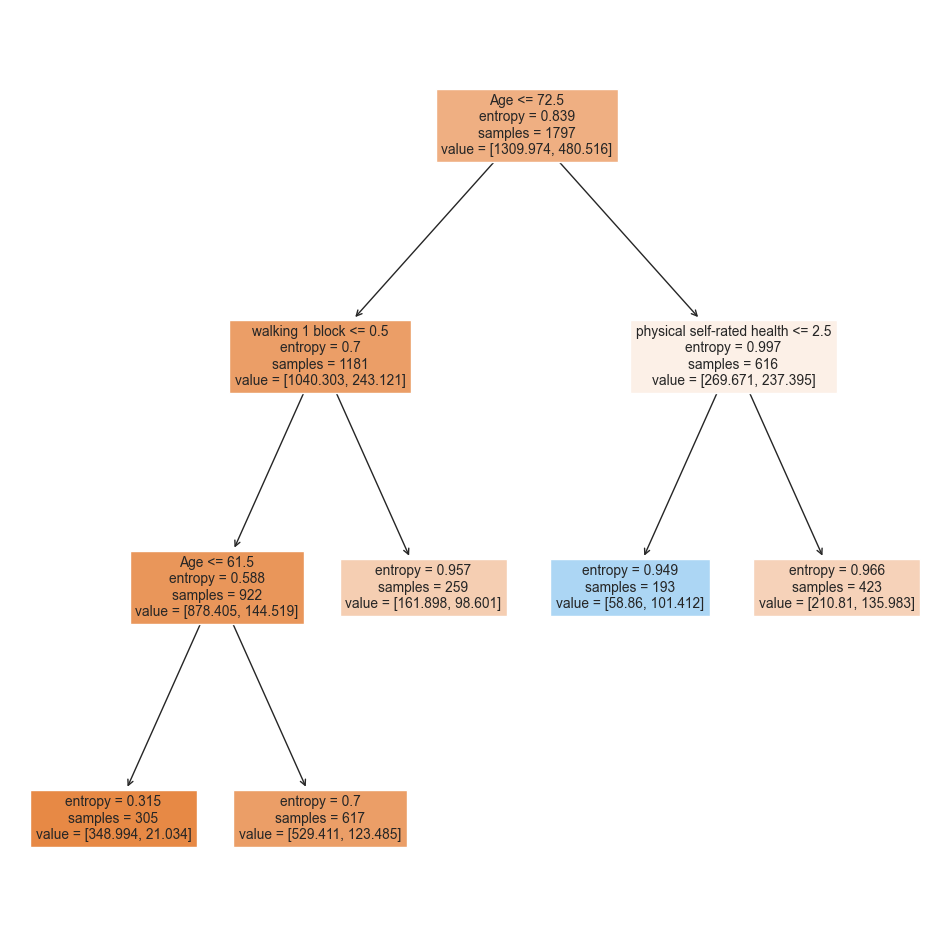

Performence on train set 0.7553939293521232
Performence on test set 0.7582078386781648
              precision    recall  f1-score   support

         0.0       0.77      0.95      0.85 443.2256796807058
         1.0       0.62      0.23      0.33 159.910779565578

    accuracy                           0.76 603.1364592462838
   macro avg       0.70      0.59      0.59 603.1364592462838
weighted avg       0.73      0.76      0.71 603.1364592462838



In [198]:
DT_clf = tree.DecisionTreeClassifier(random_state=seed, criterion="entropy", max_depth=None,
                                     min_impurity_decrease=0.01)
DT_clf.fit(X_train.drop(columns='Weight', inplace=False), y_train, sample_weight=X_train['Weight'])

plt.figure(figsize=(12, 12))
tree.plot_tree(DT_clf, filled=True, feature_names=feature_names)
plt.show()

print("Performence on train set",
      metrics.accuracy_score(DT_clf.predict(X_train.drop(columns='Weight', inplace=False)), y_train,
                             sample_weight=X_train['Weight']))
y_pred = pd.DataFrame(DT_clf.predict(X_test.drop(columns='Weight', inplace=False)), columns=["deceased"])
print("Performence on test set", metrics.accuracy_score(y_pred, y_test, sample_weight=X_test['Weight']))

print(metrics.classification_report(y_test, y_pred, sample_weight=X_test['Weight']))

In [199]:
DT_clf.feature_importances_

array([0.65289005, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.09598371, 0.        , 0.        , 0.25112623])

## Random Forest

In [104]:
RF_clf = ensemble.RandomForestClassifier(random_state=seed, n_estimators=100, criterion='entropy',
                                         min_impurity_decrease=0.01)
RF_clf.fit(X_train.drop(columns='Weight', inplace=False), y_train, sample_weight=X_train['Weight'], )

print("Performence on train set",
      metrics.accuracy_score(RF_clf.predict(X_train.drop(columns='Weight', inplace=False)), y_train,
                             sample_weight=X_train['Weight']))
y_pred = pd.DataFrame(RF_clf.predict(X_test.drop(columns='Weight', inplace=False)), columns=["deceased"])
print("Performence on test set", metrics.accuracy_score(y_pred, y_test, sample_weight=X_test['Weight']))

print(metrics.classification_report(y_test, y_pred, sample_weight=X_test['Weight']))

Performence on train set 0.7330731495532726
Performence on test set 0.736774516547192
              precision    recall  f1-score   support

         0.0       0.74      1.00      0.85 443.2256796807058
         1.0       1.00      0.01      0.01 159.910779565578

    accuracy                           0.74 603.1364592462838
   macro avg       0.87      0.50      0.43 603.1364592462838
weighted avg       0.81      0.74      0.63 603.1364592462838



/var/folders/zw/thvqht1n2q9ggd09wgsw76th0000gn/T/ipykernel_37312/2440771295.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF_clf.fit(X_train.drop(columns='Weight', inplace=False), y_train, sample_weight=X_train['Weight'], )


0.7473782287944237


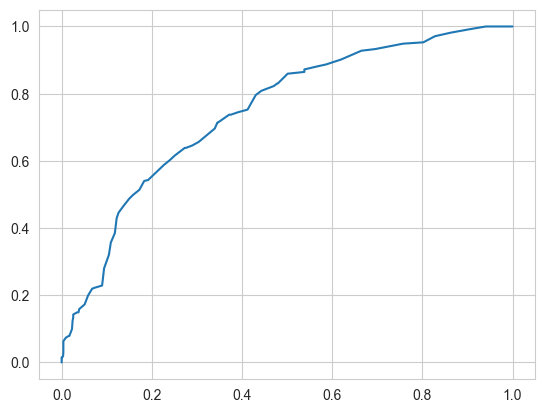

In [167]:
y_prob = pd.DataFrame(RF_clf.predict_proba(X_test.drop(columns='Weight', inplace=False))[:, 1], columns=["deceased"])
fpr, tpr, thr = metrics.roc_curve(y_test, y_prob, sample_weight=X_test['Weight'])
plt.plot(fpr, tpr)
print(metrics.roc_auc_score(y_test, y_prob, sample_weight=X_test['Weight']))

In [170]:
RF_clf = ensemble.RandomForestClassifier(random_state=seed, n_estimators=45, criterion='entropy',
                                         min_impurity_decrease=3e-3)
RF_clf.fit(X_train.drop(columns='Weight', inplace=False), y_train, sample_weight=X_train['Weight'], )

print("Performence on train set",
      metrics.accuracy_score(RF_clf.predict(X_train.drop(columns='Weight', inplace=False)), y_train,
                             sample_weight=X_train['Weight']))
y_pred = pd.DataFrame(RF_clf.predict(X_test.drop(columns='Weight', inplace=False)), columns=["deceased"])
print("Performence on test set", metrics.accuracy_score(y_pred, y_test, sample_weight=X_test['Weight']))

print(metrics.classification_report(y_test, y_pred, sample_weight=X_test['Weight']))

Performence on train set 0.8243318590354463
Performence on test set 0.7637635655436182
              precision    recall  f1-score   support

         0.0       0.77      0.98      0.86 443.2256796807058
         1.0       0.74      0.17      0.27 159.910779565578

    accuracy                           0.76 603.1364592462838
   macro avg       0.75      0.57      0.57 603.1364592462838
weighted avg       0.76      0.76      0.70 603.1364592462838



/var/folders/zw/thvqht1n2q9ggd09wgsw76th0000gn/T/ipykernel_37312/330440882.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF_clf.fit(X_train.drop(columns='Weight', inplace=False), y_train, sample_weight=X_train['Weight'], )


0.7653621908024737


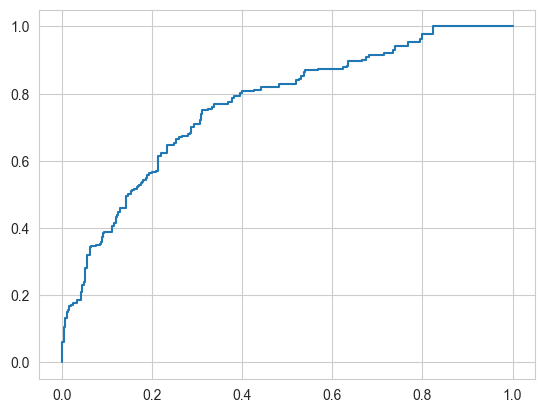

In [171]:
y_prob = pd.DataFrame(RF_clf.predict_proba(X_test.drop(columns='Weight', inplace=False))[:, 1], columns=["deceased"])
fpr, tpr, thr = metrics.roc_curve(y_test, y_prob, sample_weight=X_test['Weight'])
plt.plot(fpr, tpr)
print(metrics.roc_auc_score(y_test, y_prob, sample_weight=X_test['Weight']))

In [174]:
RF_clf = ensemble.ExtraTreesClassifier(random_state=seed, n_estimators=72, criterion='entropy', max_features=0.6,
                                       min_impurity_decrease=5e-5)
RF_clf.fit(X_train.drop(columns='Weight', inplace=False), y_train, sample_weight=X_train['Weight'])

print("Performence on train set",
      metrics.accuracy_score(RF_clf.predict(X_train.drop(columns='Weight', inplace=False)), y_train,
                             sample_weight=X_train['Weight']))
y_pred = pd.DataFrame(RF_clf.predict(X_test.drop(columns='Weight', inplace=False)), columns=["deceased"])
print("Performence on test set", metrics.accuracy_score(y_pred, y_test, sample_weight=X_test['Weight']))

print(metrics.classification_report(y_test, y_pred, sample_weight=X_test['Weight']))

/var/folders/zw/thvqht1n2q9ggd09wgsw76th0000gn/T/ipykernel_37312/2650019228.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF_clf.fit(X_train.drop(columns='Weight', inplace=False), y_train, sample_weight=X_train['Weight'])


Performence on train set 1.0
Performence on test set 0.7589652637325859
              precision    recall  f1-score   support

         0.0       0.81      0.88      0.84 443.2256796807058
         1.0       0.56      0.43      0.49 159.910779565578

    accuracy                           0.76 603.1364592462838
   macro avg       0.68      0.65      0.66 603.1364592462838
weighted avg       0.74      0.76      0.75 603.1364592462838



0.7473782287944237


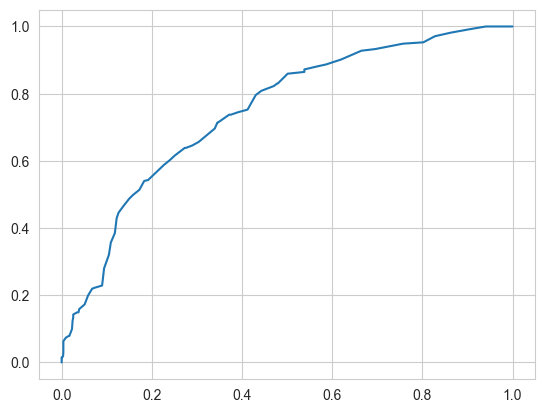

In [175]:
y_prob = pd.DataFrame(RF_clf.predict_proba(X_test.drop(columns='Weight', inplace=False))[:, 1], columns=["deceased"])
fpr, tpr, thr = metrics.roc_curve(y_test, y_prob, sample_weight=X_test['Weight'])
plt.plot(fpr, tpr)
print(metrics.roc_auc_score(y_test, y_prob, sample_weight=X_test['Weight']))

In [197]:
RF_clf.feature_importances_

array([0.15108287, 0.06739091, 0.07124141, 0.05336204, 0.0646194 ,
       0.06510217, 0.0344423 , 0.03463832, 0.04722479, 0.06021548,
       0.05487902, 0.05615224, 0.        , 0.        , 0.03323377,
       0.0760935 , 0.0569608 , 0.02025329, 0.05310769])

## Stacking

In [263]:
X_train_v, X_test, y_train_v, y_test = train_test_split(data_x, data_y,
                                                        test_size=0.2,
                                                        random_state=42)

In [267]:
clfs = [
    ("dt1", tree.DecisionTreeClassifier(random_state=seed, criterion="entropy", max_depth=None,
                                        min_impurity_decrease=0.01)),
    ("rf", ensemble.RandomForestClassifier(random_state=seed, n_estimators=45, criterion='entropy',
                                           min_impurity_decrease=3e-3)),
    ("erf", ensemble.ExtraTreesClassifier(random_state=seed, n_estimators=72, criterion='entropy', max_features=0.6,
                                          min_impurity_decrease=5e-5))
]

stk_clf = ensemble.StackingClassifier(estimators=clfs, final_estimator=LogisticRegression())
stk_clf.fit(X_train.drop(columns='Weight', inplace=False), y_train, sample_weight=X_train['Weight'])
print("Performence on train set",
      metrics.accuracy_score(stk_clf.predict(X_train.drop(columns='Weight', inplace=False)), y_train,
                             sample_weight=X_train['Weight']))
y_pred = pd.DataFrame(stk_clf.predict(X_test.drop(columns='Weight', inplace=False)), columns=["deceased"])
print("Performence on test set", metrics.accuracy_score(y_pred, y_test, sample_weight=X_test['Weight']))

print(metrics.classification_report(y_test, y_pred, sample_weight=X_test['Weight']))

/Users/lyu/Opt/anaconda3/envs/m1_torch/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lyu/Opt/anaconda3/envs/m1_torch/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Performence on train set 0.9731502207358456
Performence on test set 0.7617361919600347
              precision    recall  f1-score   support

         0.0       0.79      0.92      0.85 443.2256796807058
         1.0       0.59      0.33      0.42 159.910779565578

    accuracy                           0.76 603.1364592462838
   macro avg       0.69      0.62      0.64 603.1364592462838
weighted avg       0.74      0.76      0.74 603.1364592462838



0.7649490135969066


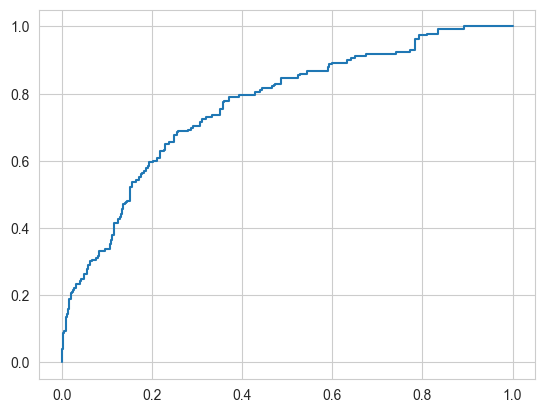

In [269]:
y_prob = pd.DataFrame(stk_clf.predict_proba(X_test.drop(columns='Weight', inplace=False))[:, 1], columns=["deceased"])
fpr, tpr, thr = metrics.roc_curve(y_test, y_prob, sample_weight=X_test['Weight'])
plt.plot(fpr, tpr)
print(metrics.roc_auc_score(y_test, y_prob, sample_weight=X_test['Weight']))

In [274]:
ftr_sig = pd.DataFrame(columns=feature_names)
for clf in stk_clf.estimators_:
    ftr_sig.loc[len(ftr_sig)] = clf.feature_importances_
ftr_sig

,Age,Systolic BP,BMI,HbA1c,CRP,DHEA,smoker,alcohol,physical activity,sleep,education,wealth,married,black race,gender,physical self-rated health,mental self-rated health,chronic conditions,walking 1 block
0,0.652890,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.095984,0.000000,0.000000,0.251126
1,0.252647,0.059502,0.083421,0.046115,0.074405,0.066658,0.039148,0.007828,0.027264,0.018950,0.030484,0.025229,0.0,0.0,0.027123,0.108798,0.027875,0.017429,0.087125
2,0.151083,0.067391,0.071241,0.053362,0.064619,0.065102,0.034442,0.034638,0.047225,0.060215,0.054879,0.056152,0.0,0.0,0.033234,0.076094,0.056961,0.020253,0.053108


In [283]:
X_wrong = X_test.reset_index(inplace=False).drop(columns='index', inplace=False).loc[
    y_pred['deceased'] != y_test.reset_index(inplace=False)['deceased']
    ].drop(columns='Weight', inplace=False)

y_wrong = y_test.reset_index(inplace=False).drop(columns='index', inplace=False).loc[
    y_pred['deceased'] != y_test.reset_index(inplace=False)['deceased']
    ]
y_wrong_pred = y_prob.reset_index(inplace=False).drop(columns='index', inplace=False).loc[
    y_pred['deceased'] != y_test.reset_index(inplace=False)['deceased']
    ]
y_wrong['deceased'].value_counts()

1.0    112
0.0     41
Name: deceased, dtype: int64

In [285]:
preds = []
for clf in stk_clf.estimators_:
    pred = []
    for idx, ftr in X_wrong.iterrows():
        pred.append(float(clf.predict_proba(np.array(ftr).reshape(1, -1))[:, 1]))
    preds.append(pred)
predict_outcomes = pd.DataFrame({
    'DT': preds[0],
    'RF': preds[1],
    'E_RF': preds[2],
    'Pred': y_wrong_pred['deceased'],
    'True': y_wrong['deceased']
})
print(stk_clf.final_estimator_.coef_)
predict_outcomes.head()

/Users/lyu/Opt/anaconda3/envs/m1_torch/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/lyu/Opt/anaconda3/envs/m1_torch/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/lyu/Opt/anaconda3/envs/m1_torch/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/lyu/Opt/anaconda3/envs/m1_torch/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/lyu/Opt/anaconda3/envs/m1_torch/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTr

[[0.68800915 3.27123536 1.79347473]]


/Users/lyu/Opt/anaconda3/envs/m1_torch/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/Users/lyu/Opt/anaconda3/envs/m1_torch/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/Users/lyu/Opt/anaconda3/envs/m1_torch/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/Users/lyu/Opt/anaconda3/envs/m1_torch/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/Users/lyu/Opt/anaconda3/envs/m1_torch/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesClassifi

,DT,RF,E_RF,Pred,True
0,0.392116,0.456881,0.583333,0.514505,0.0
3,0.392116,0.332281,0.527778,0.389552,1.0
10,0.189135,0.292169,0.500000,0.316504,1.0
12,0.632747,0.460751,0.305556,0.434888,1.0
13,0.378509,0.528515,0.486111,0.527133,0.0


In [284]:
X_wrong.head()

,Age,Systolic BP,BMI,HbA1c,CRP,DHEA,smoker,alcohol,physical activity,sleep,education,wealth,married,black race,gender,physical self-rated health,mental self-rated health,chronic conditions,walking 1 block
0,77.0,159.5,32.196568,6.600000,9.87200,40.620001,1.0,0.0,1.0,9.0,2.0,4.000000,0,0,1.0,3.0,5.0,0.0,0.0
3,78.0,156.5,26.431152,6.097641,3.19458,52.921454,0.0,0.0,4.0,6.0,2.0,3.649512,0,0,2.0,3.0,4.0,0.0,0.0
10,69.0,105.5,29.383953,5.500000,0.77400,52.921454,0.0,0.0,1.0,8.0,2.0,3.649512,0,0,1.0,2.0,2.0,0.0,0.0
12,81.0,117.0,36.246258,5.400000,3.16900,10.695000,0.0,0.0,1.0,5.0,1.0,4.000000,0,0,2.0,2.0,3.0,0.0,2.0
13,63.0,134.0,29.700710,6.097641,7.03700,52.921454,1.0,0.0,0.0,5.0,2.0,2.000000,0,0,2.0,2.0,5.0,0.0,1.0


In [287]:
ftr_sig

,Age,Systolic BP,BMI,HbA1c,CRP,DHEA,smoker,alcohol,physical activity,sleep,education,wealth,married,black race,gender,physical self-rated health,mental self-rated health,chronic conditions,walking 1 block
0,0.652890,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.095984,0.000000,0.000000,0.251126
1,0.252647,0.059502,0.083421,0.046115,0.074405,0.066658,0.039148,0.007828,0.027264,0.018950,0.030484,0.025229,0.0,0.0,0.027123,0.108798,0.027875,0.017429,0.087125
2,0.151083,0.067391,0.071241,0.053362,0.064619,0.065102,0.034442,0.034638,0.047225,0.060215,0.054879,0.056152,0.0,0.0,0.033234,0.076094,0.056961,0.020253,0.053108


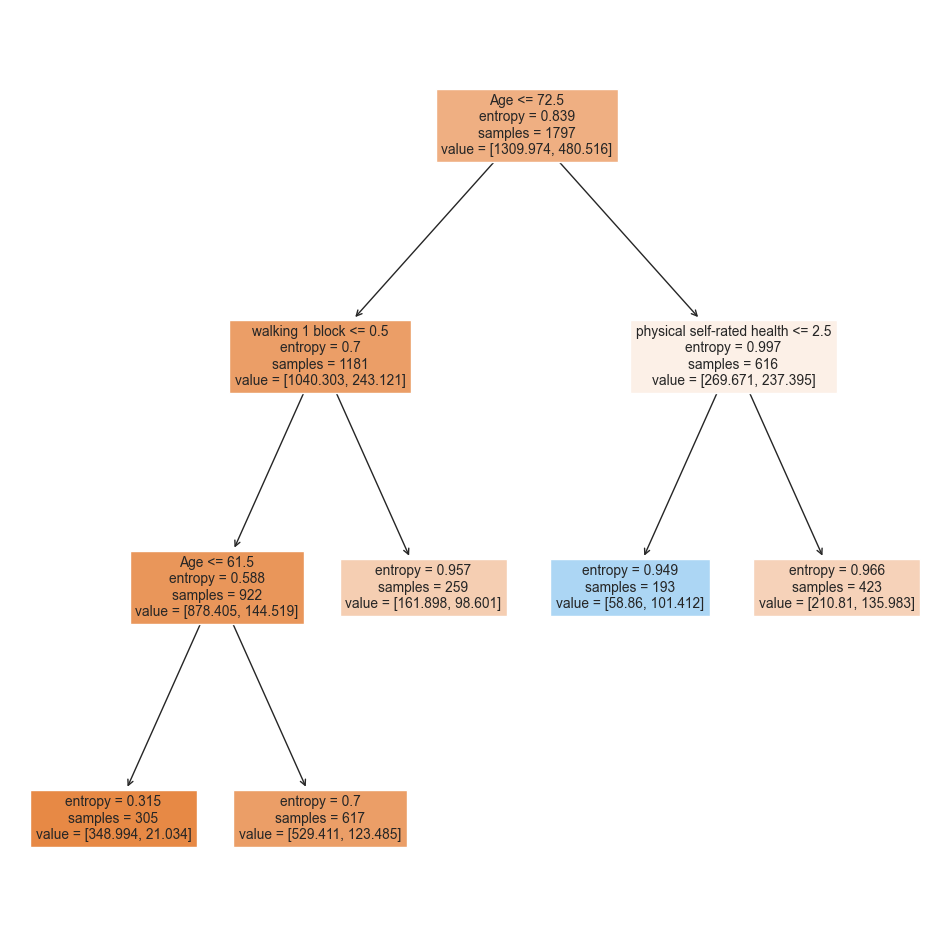

In [289]:
plt.figure(figsize=(12, 12))
tree.plot_tree(stk_clf.estimators_[0], filled=True, feature_names=feature_names)
plt.show()

In [308]:
class Stacking_CLF():
    def __init__(self, n_folds=2, n_esti=25, max_depth=6, min_sample=2, tr_weight=None, weight=None, seed=42):
        self.clfs = []
        for i in range(n_folds):
            self.clfs.append(
                [tree.DecisionTreeClassifier(random_state=seed, criterion="entropy", max_depth=None,
                                             min_impurity_decrease=0.01),
                 ensemble.RandomForestClassifier(random_state=seed, n_estimators=45, criterion='entropy',
                                                 min_impurity_decrease=3e-3),
                 ensemble.ExtraTreesClassifier(random_state=seed, n_estimators=72, criterion='entropy',
                                               max_features=0.6,
                                               min_impurity_decrease=5e-5)])
        self.n_base = len(self.clfs[0])
        self.n_folds = n_folds
        self.meta = LogisticRegression(class_weight=weight, n_jobs=-1)

    def fit(self, X, y):

        X_train_v = np.array(X)
        y_train_v = np.array(y)
        dataset_blend_train = np.zeros((X_train_v.shape[0], self.n_base))

        skf = StratifiedKFold(self.n_folds).split(X_train_v, y_train_v)
        skf = list(skf)
        for j in range(self.n_base):
            for i, (train, test) in enumerate(skf):
                X_train = X_train_v[train]
                y_train = y_train_v[train]
                X_test_temp = X_train_v[test]
                self.clfs[i][j].fit(X_train, np.ravel(y_train))
                y_submission = self.clfs[i][j].predict_proba(X_test_temp)[:, 1]
                dataset_blend_train[test, j] = y_submission

        self.meta.fit(dataset_blend_train, y_train_v)

    def predict(self, X, proba=True):
        X_test = np.array(X)
        dataset_blend_test = np.zeros((X_test.shape[0], self.n_base))

        for j in range(self.n_base):
            dataset_blend_test_j = np.zeros((X_test.shape[0], self.n_folds))
            for i in range(self.n_folds):
                dataset_blend_test_j[:, i] = self.clfs[i][j].predict_proba(X_test)[:, 1]
            dataset_blend_test[:, j] = dataset_blend_test_j.mean(1)

        if proba:
            return self.meta.predict_proba(dataset_blend_test)[:, 1]
        else:
            return self.meta.predict(dataset_blend_test)

    def get_log_param(self):
        return self.meta.get_params()

    def get_coeff(self):
        return self.meta.coef_

    def get_clf(self):
        return self.clfs


In [309]:
stk_clfa = Stacking_CLF(n_folds=8, n_esti=25, max_depth=8, seed=42)
stk_clfa.fit(X_train_v, y_train_v)
print(stk_clfa.get_coeff())
print(metrics.accuracy_score(stk_clfa.predict(X_train_v, proba=False), y_train_v))
print(metrics.accuracy_score(stk_clfa.predict(X_test, proba=False), y_test))

/Users/lyu/Opt/anaconda3/envs/m1_torch/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[2.06358621 0.52281302 1.94359278 1.94711046 0.53881673]]
0.8681135225375626
0.7462437395659433


In [310]:
stk_clfb = Stacking_CLF(n_folds=8, n_esti=30, max_depth=8, seed=42)
stk_clfb.fit(X_train_v, y_train_v)
print(stk_clfb.get_coeff())
print(metrics.accuracy_score(stk_clfb.predict(X_train_v, proba=False), y_train_v))
print(metrics.accuracy_score(stk_clfb.predict(X_test, proba=False), y_test))

/Users/lyu/Opt/anaconda3/envs/m1_torch/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[2.15678977 0.41212088 1.82373589 1.93096144 0.6840466 ]]
0.8693656093489148
0.7462437395659433


In [311]:
stk_clfb = Stacking_CLF(n_folds=8, n_esti=20, max_depth=8, seed=42)
stk_clfb.fit(X_train_v, y_train_v)
print(stk_clfb.get_coeff())
print(metrics.accuracy_score(stk_clfb.predict(X_train_v, proba=False), y_train_v))
print(metrics.accuracy_score(stk_clfb.predict(X_test, proba=False), y_test))

/Users/lyu/Opt/anaconda3/envs/m1_torch/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[1.85368373 0.89811378 1.70009929 1.97262101 0.59176895]]
0.8693656093489148
0.7495826377295493


In [312]:
stk_clfb = Stacking_CLF(n_folds=9, n_esti=15, max_depth=3, seed=42)
stk_clfb.fit(X_train_v, y_train_v)
print(stk_clfb.get_coeff())
print(metrics.accuracy_score(stk_clfb.predict(X_train_v, proba=False), y_train_v))
print(metrics.accuracy_score(stk_clfb.predict(X_test, proba=False), y_test))

/Users/lyu/Opt/anaconda3/envs/m1_torch/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[3.02016657 0.70662372 2.60432485 1.32050441 3.23023761]]
0.7658597662771286
0.7529215358931552


In [313]:
stk_clfb = Stacking_CLF(n_folds=10, n_esti=15, max_depth=3, seed=42, weight='balanced')
stk_clfb.fit(X_train_v, y_train_v)
print(stk_clfb.get_coeff())
print(metrics.accuracy_score(stk_clfb.predict(X_train_v, proba=False), y_train_v))
print(metrics.accuracy_score(stk_clfb.predict(X_test, proba=False), y_test))

/Users/lyu/Opt/anaconda3/envs/m1_torch/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[2.49507434 1.7704998  2.81368766 1.17904339 3.23765674]]
0.7199499165275459
0.6894824707846411


In [320]:
print("Best performence at 42", metrics.accuracy_score(stk_clfb.predict(X_test, proba=False), y_test))
stk_clfb = Stacking_CLF(n_folds=9, n_esti=18, max_depth=3, seed=42, tr_weight='balanced_subsample')
stk_clfb.fit(X_train_v, y_train_v)
print(stk_clfb.get_coeff())
print(metrics.accuracy_score(stk_clfb.predict(X_train_v, proba=False), y_train_v))
print(metrics.accuracy_score(stk_clfb.predict(X_test, proba=False), y_test))

Best performence at 42 0.7479131886477463


/Users/lyu/Opt/anaconda3/envs/m1_torch/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[1.94462005 1.14903739 2.3467746  1.34681972 3.21516931]]
0.7650250417362271
0.7479131886477463


In [331]:
print("Best performence at 42", metrics.accuracy_score(stk_clfb.predict(X_test, proba=False), y_test))
stk_clfb = Stacking_CLF(n_folds=15, n_esti=18, max_depth=3, seed=42, tr_weight='balanced_subsample')
stk_clfb.fit(X_train_v, y_train_v)
print(stk_clfb.get_coeff())
print(metrics.accuracy_score(stk_clfb.predict(X_train_v, proba=False), y_train_v))
print(metrics.accuracy_score(stk_clfb.predict(X_test, proba=False), y_test))

Best performence at 42 0.7495826377295493


/Users/lyu/Opt/anaconda3/envs/m1_torch/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[1.45292294 1.48676291 2.41081869 1.62534347 3.14304136]]
0.7662771285475793
0.7545909849749582


0.7733423180592991

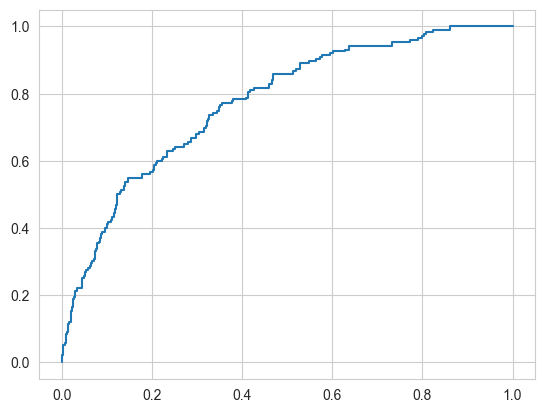

In [332]:
y_prob = stk_clfb.predict(X_test, proba=True)
y_sp = stk_clfb.predict(X_test, proba=False)
fpr, tpr, thr = metrics.roc_curve(y_test, y_prob)
plt.plot(fpr, tpr)
metrics.roc_auc_score(y_test, y_prob)

In [333]:
rf_clusters = stk_clfb.get_clf()
for i, cluster in enumerate(rf_clusters[:4]):

    for j, rf in enumerate(cluster[:-1]):
        print(rf)
        dot_data = tree.export_graphviz(rf.estimators_[0], out_file=None,
                                        filled=True, rounded=True,
                                        special_characters=True,
                                        feature_names=predictor_names,
                                        class_names=['Alive', 'Deceased'])
        graph = graphviz.Source(dot_data)
        graph.render(str(i) + "_nshap0_" + str(j))
        print(i, j)
for i, cluster in enumerate(rf_clusters[:4]):

    for j, rf in enumerate(cluster[:-1]):
        print(rf)
        dot_data = tree.export_graphviz(rf.estimators_[9], out_file=None,
                                        filled=True, rounded=True,
                                        special_characters=True,
                                        feature_names=predictor_names,
                                        class_names=['Alive', 'Deceased'])
        graph = graphviz.Source(dot_data)
        graph.render(str(i) + "_nshap9_" + str(j))
        print(i, j)
for i, cluster in enumerate(rf_clusters[:4]):

    for j, rf in enumerate(cluster[:-1]):
        print(rf)
        dot_data = tree.export_graphviz(rf.estimators_[17], out_file=None,
                                        filled=True, rounded=True,
                                        special_characters=True,
                                        feature_names=predictor_names,
                                        class_names=['Alive', 'Deceased'])
        graph = graphviz.Source(dot_data)
        graph.render(str(i) + "_nshap17_" + str(j))
        print(i, j)

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=3, n_estimators=18, n_jobs=-1,
                       random_state=42)
0 0
RandomForestClassifier(class_weight='balanced_subsample', max_depth=3,
                       n_estimators=18, n_jobs=-1, random_state=43)
0 1
ExtraTreesClassifier(class_weight='balanced_subsample', criterion='entropy',
                     max_depth=3, n_estimators=18, n_jobs=-1, random_state=44)
0 2
ExtraTreesClassifier(class_weight='balanced_subsample', max_depth=3,
                     n_estimators=18, n_jobs=-1, random_state=45)
0 3
RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=3, n_estimators=18, n_jobs=-1,
                       random_state=42)
1 0
RandomForestClassifier(class_weight='balanced_subsample', max_depth=3,
                       n_estimators=18, n_jobs=-1, random_state=43)
1 1
ExtraTreesClassifier(class_weight='balanc

In [334]:
X_test.columns = predictor_names

In [352]:
y_sp = np.array(y_sp)
gt = list(dict(y_test)['deceased'])
gt = np.array(gt)
f_idx = np.reshape(np.argwhere(y_sp != gt), [-1])
X_wrong = X_test.iloc[f_idx]
X_wrong['deceased'] = y_sp[f_idx]
X_wrong

/var/folders/zw/thvqht1n2q9ggd09wgsw76th0000gn/T/ipykernel_36672/1112926933.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_wrong['deceased']=y_sp[f_idx]


,Age,Systolic BP,BMI,HbA1c,CRP,DHEA,smoker,alcohol,physical activity,sleep,education,wealth,married,black race,gender,physical self-rated health,mental self-rated health,chronic conditions,walking 1 block,deceased
1374,4.771983,2.971285,0.742092,0.783655,0.678735,-0.202921,10.000000,-12.434457,-22.262118,3.477911,-3.281596,2.675545,NaN,NaN,-11.546763,-0.887143,10.000000,-1.519231,-1.783607,1.0
2110,2.811477,-0.639799,-0.338796,0.048748,-0.011860,-0.144557,-1.519231,-12.434457,10.000000,3.477911,-9.922395,0.108414,NaN,NaN,10.000000,-6.330715,-5.834772,-1.519231,2.144262,1.0
2097,5.425485,2.584383,-0.778440,0.048748,-0.011860,0.031709,-1.519231,-12.434457,10.000000,-1.413655,-3.281596,0.108414,NaN,NaN,10.000000,-0.887143,2.082614,-1.519231,-1.783607,0.0
1017,-0.456033,-3.992947,0.000312,-0.825548,-0.262203,0.031709,-1.519231,-12.434457,-22.262118,1.847389,-3.281596,0.108414,NaN,NaN,-11.546763,-6.330715,-13.752159,-1.519231,-1.783607,0.0
144,-8.298058,4.712343,-0.959499,0.637364,-0.159297,3.327560,-1.519231,-12.434457,10.000000,-3.044177,3.359202,-19.297822,NaN,NaN,10.000000,-6.330715,2.082614,10.000000,2.144262,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,-1.763037,-1.155668,0.770493,0.048748,0.249015,0.304526,-1.519231,10.000000,10.000000,-3.044177,-9.922395,0.108414,NaN,NaN,10.000000,-11.774286,-5.834772,10.000000,2.144262,0.0
2582,-5.684050,-1.349118,5.551726,-0.240383,3.613039,-0.800776,-1.519231,-12.434457,-11.508079,1.847389,-9.922395,2.675545,NaN,NaN,-11.546763,-6.330715,-5.834772,-1.519231,10.000000,0.0
2225,-6.337552,0.087349,-0.075851,0.048748,-0.011860,0.031709,10.000000,-12.434457,10.000000,1.847389,-3.281596,0.108414,NaN,NaN,-11.546763,-6.330715,2.082614,-1.519231,2.144262,0.0
1023,5.425485,-0.962217,-1.553920,-1.410713,-0.040051,-0.418260,-1.519231,10.000000,10.000000,1.847389,-9.922395,2.675545,NaN,NaN,-11.546763,-0.887143,10.000000,-1.519231,-1.783607,0.0


In [337]:
s_idx = np.reshape(np.argwhere(y_sp == gt), [-1])
X_right = X_test.iloc[s_idx]
X_right['deceased'] = y_sp[s_idx]
X_right

/var/folders/zw/thvqht1n2q9ggd09wgsw76th0000gn/T/ipykernel_36672/1822508282.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_right['deceased']=y_sp[s_idx]


,Age,Systolic BP,BMI,HbA1c,CRP,DHEA,smoker,alcohol,physical activity,sleep,education,wealth,married,black race,gender,physical self-rated health,mental self-rated health,chronic conditions,walking 1 block,deceased
321,59.0,148.0,28.500000,6.097641,3.19458,56.285000,0.0,0.0,3.0,6.0,1.0,3.649512,0,0,1.0,3.0,4.0,0.0,0.0,0.0
1578,73.0,152.0,30.417559,5.400000,5.46500,127.855000,0.0,1.0,4.0,9.0,4.0,3.649512,0,0,1.0,4.0,4.0,0.0,0.0,0.0
178,75.0,103.5,30.056837,6.097641,1.14300,27.895000,0.0,1.0,4.0,8.0,2.0,4.000000,0,0,1.0,3.0,3.0,0.0,0.0,0.0
495,68.0,107.0,30.712875,5.500000,3.17500,142.695000,0.0,1.0,4.0,8.0,1.0,3.000000,0,0,1.0,2.0,3.0,0.0,1.0,0.0
471,67.0,152.5,23.289228,6.097641,3.19458,52.921454,0.0,1.0,4.0,8.0,2.0,3.649512,0,0,1.0,5.0,5.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1610,63.0,143.5,34.942013,5.600000,2.86800,59.215000,0.0,0.0,3.0,5.0,3.0,2.000000,0,0,2.0,4.0,4.0,0.0,0.0,0.0
2337,62.0,146.5,36.540760,6.000000,8.94300,52.921454,0.0,1.0,4.0,6.0,1.0,3.649512,0,0,1.0,3.0,3.0,0.0,0.0,0.0
1192,74.0,124.0,30.550123,6.097641,1.96900,7.330000,0.0,0.0,4.0,6.0,2.0,2.000000,0,0,2.0,4.0,4.0,0.0,0.0,0.0
226,73.0,124.0,26.356962,6.900000,1.96100,48.695000,0.0,0.0,0.0,7.0,2.0,5.000000,0,0,1.0,1.0,5.0,0.0,0.0,1.0


In [ ]:
# tsne降维可视化
# 讨论stacking的实现细节

In [349]:
X_test_new = X_test
for idx in list(X_test_new.columns):
    X_test_new[idx] = (X_test_new[idx] - X_test_new[idx].mean()) / (X_test_new[idx].max() - X_test_new[idx].mean()) * 10
X_test_new = X_test_new.drop(columns=['married', 'black race'])

/Users/lyu/Opt/anaconda3/envs/m1_torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


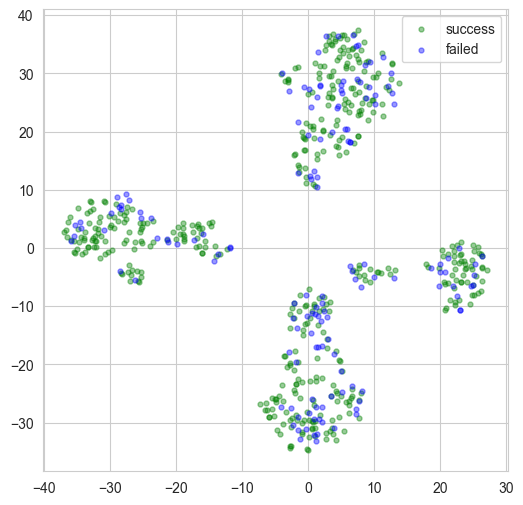

In [354]:

x_train = np.array(X_test_new)
x_tsne = TSNE(n_components=2, learning_rate=100, random_state=501).fit_transform(x_train)

plt.figure(figsize=(6, 6))
r = 2  # 4ls

area = np.pi * r ** 2  # 点面积

plt.scatter(x_tsne[s_idx, 0], x_tsne[s_idx, 1], s=area, c='g', alpha=0.4, label='success')
plt.scatter(x_tsne[f_idx, 0], x_tsne[f_idx, 1], s=area, c='b', alpha=0.4, label='failed')
plt.legend()
#plt.savefig(name)
plt.show()

In [ ]:
#onehot
#validation
#model performence interpretation
#wrong sample

##decision tree classifier,
##根据observation在develop下一步改变